## Experiment: Using 3D measurements

**Strategy:**  The previous notebook only used magnitude of acceleration and actually did quite well (in my opinion).  But I believe that there may be even richer information in the 3D data.

Steps:

* Calculate acceleration-magnitude vector as in experiment 1.  Put this aside.
* For each Nx3 sample, calculate the _mean_ value in each of x, y, and z dimensions.  This will estimate the direction of gravity if the person stopped walking.
* Calculate rotation matrix to rotate avg vector towards -z (0,0,-1).  Apply rotation matrix to all vectors in sample (choice of -z is arbitrary, any fixed vector would be fine)
* For all points, calculate latitude and longitude of the vector projected on the unit sphere
* For all N latitudes, compute N-1 latitude differences (dLat/dt), compute periodogram
* For all N longitudes, compute N-1 longitude differences (dLon/dt), compute periodogram
* Concatenate magnitude, d_latitude, d_longitude periodograms
* Use same L2-based KNN as in experiment #1

**SPOILER:** It actually worked quite well! 
1. Experiment #1 (Magnitude only): 62% accuracy, 53% unweighted average across all classes
2. Experiment #2 (Spherical features): 71% accuracy, 66% unweighted average!  

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy
import seaborn as sns
import sklearn
import time
from accel_utils import AccelUtils, AccelUtils3D
from train_utils import TrainUtils

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import DistanceMetric

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
params = AccelUtils.read_params_file('params.json')
num_subj = params['num_subj']
max_resample_pts = params['max_resample_pts']
min_timesteps_per_sample = int(params['max_resample_pts'] * params['filt_min_timesteps_per_sample_ratio'])
per_user_all_data = AccelUtils.read_all_user_data(params['data_dir'], num_subj)
valid_windows_by_user = {}
for i in range(num_subj):
    df = per_user_all_data[i]
    valid_windows_by_user[i] = AccelUtils.extract_valid_time_windows_for_subj(
        df,
        params['window_size_sec'],
        min_timesteps_per_sample)

min_samples = params['filt_min_samples_per_subj']
counts = [len(valid_windows_by_user[i]) for i in range(num_subj)]
use_subjs = [i for i in range(num_subj) if counts[i] >= min_samples]
print(f'Keeping {len(use_subjs)} subjects {use_subjs}')

Params:
{
  "data_dir": "./user_data",
  "filt_avg_power": 2.0,
  "filt_dc_ratio": 0.7,
  "filt_power_ratio": 0.5,
  "filt_min_samples_per_subj": 8,
  "max_dt": 0.035,
  "filt_min_timesteps_per_sample_ratio": 0.9,
  "resample_dt": 0.03,
  "window_size_sec": 4.3,
  "num_subj": 22,
  "max_resample_pts": 139,
  "min_timesteps_per_sample": 125
}
Number of files/subjects: 22
Each sample will be 139 time steps
Keeping 16 subjects [0, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 19, 21]


In [4]:
valid_windows_by_user[0][0].head()


,t,x_acc,y_acc,z_acc,mag_acc
700,21.51,-4.2495,12.149,-1.0760,12.915658
701,21.54,-3.6366,13.566,-1.1169,14.089311
702,21.57,-3.7865,13.866,-1.8796,14.496083
703,21.60,-3.3370,12.790,-3.5958,13.698520
704,21.63,-2.9829,10.038,-4.0589,11.230931


In [5]:
test_window = valid_windows_by_user[0][0].copy()
rotate_mtrx, grav_est = AccelUtils3D.estimate_gravity_and_rotation_matrix(test_window)
print('Testing rotation...')
print('\n  Rotation matrix:\n', rotate_mtrx)
print('\n  Gravity estimate:', grav_est)
print('\n  Gravity est after rotation:', ','.join([f'{v:.3f}' for v in rotate_mtrx.dot(grav_est).tolist()]))

Testing rotation...

  Rotation matrix:
 [[ 0.92429324  0.23847764 -0.29801079]
 [ 0.23847764  0.24879124  0.93873923]
 [ 0.29801079 -0.93873923  0.17308447]]

  Gravity estimate: [-0.29801079  0.93873923 -0.17308447]

  Gravity est after rotation: 0.000,-0.000,-1.000


^ Successfully rotated mean accel vector to -z

In [6]:
print('Average of rotated time slice (Earth\'s gravity is 9.81 m/s2)')
AccelUtils3D.align_window_acc_to_gravity(test_window, with_norm=False)
print(test_window[['x_rot', 'y_rot', 'z_rot']].mean())
AccelUtils3D.align_window_acc_to_gravity(test_window, with_norm=True)
print(test_window[['x_rot', 'y_rot', 'z_rot']].mean())
test_window.head()

print('All Data', test_window.shape)
print('dLat/dt', AccelUtils3D.compute_first_order_longitudes(test_window).shape)
print('dLon/dt', AccelUtils3D.compute_first_order_latitudes(test_window).shape)

Average of rotated time slice (Earth's gravity is 9.81 m/s2)
x_rot   -1.798249e-17
y_rot   -7.005351e-16
z_rot   -9.886914e+00
dtype: float64
x_rot   -0.010591
y_rot    0.016938
z_rot   -0.962400
dtype: float64
All Data (142, 8)
dLat/dt (141,)
dLon/dt (141,)


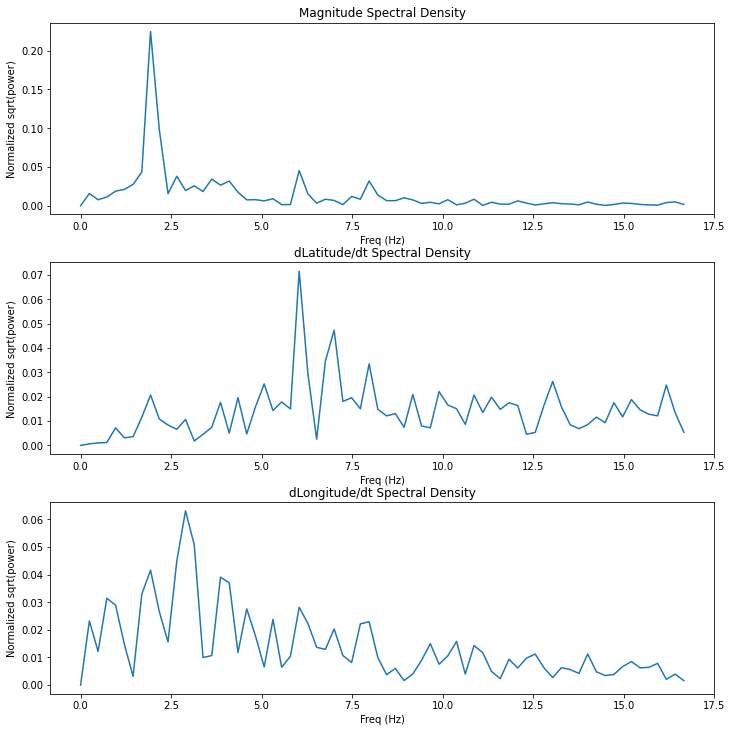

In [7]:

def convert_subj_df_to_three_periodograms(subj_window_df, resample_dt):
    fs, mag_per = AccelUtils.compute_periodogram(subj_window_df,
                                                 resample_dt,
                                                 max_resample_pts)

    _, x_resampled = AccelUtils.resample_and_truncate(subj_window_df,
                                                      resample_dt,
                                                      max_resample_pts,
                                                      col='x_acc')
    _, y_resampled = AccelUtils.resample_and_truncate(subj_window_df,
                                                      resample_dt,
                                                      max_resample_pts,
                                                      col='y_acc')
    t, z_resampled = AccelUtils.resample_and_truncate(subj_window_df,
                                                      resample_dt,
                                                      max_resample_pts,
                                                      col='z_acc')

    resampled_df = pd.DataFrame.from_records(
        zip(t, x_resampled, y_resampled, z_resampled),
        columns=['t', 'x_acc', 'y_acc', 'z_acc'])

    AccelUtils3D.align_window_acc_to_gravity(resampled_df, with_norm=True)
    dlat_seq = AccelUtils3D.compute_first_order_latitudes(resampled_df)
    dlon_seq = AccelUtils3D.compute_first_order_longitudes(resampled_df)
    fs, dlat_per = AccelUtils3D.angle_periodogram(dlat_seq, params['resample_dt'])
    fs, dlon_per =  AccelUtils3D.angle_periodogram(dlon_seq, params['resample_dt'])
    return fs, mag_per, dlat_per, dlon_per, resampled_df

fs, mag_per, lat, lon, redf = convert_subj_df_to_three_periodograms(
    test_window, params['resample_dt'])
fig,axs = plt.subplots(3, 1, figsize=(10, 10))
axs[0].plot(fs, mag_per)
axs[0].set_title('Magnitude Spectral Density')
axs[1].plot(fs, lat)
axs[1].set_title('dLatitude/dt Spectral Density')
axs[2].plot(fs, lon)
axs[2].set_title('dLongitude/dt Spectral Density')
for i in range(3):
    axs[i].set_xlabel('Freq (Hz)')
    axs[i].set_ylabel('Normalized sqrt(power)')
fig.tight_layout(pad=0.1)

Total Row Count: 616


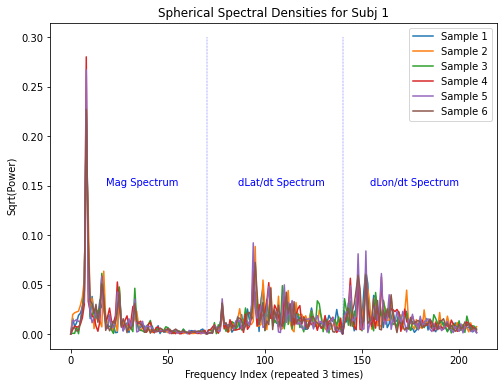

In [8]:

all_rows = []
fig,ax = plt.subplots(figsize=(8,6))
for i_subj in use_subjs:
    for i_win, window in enumerate(valid_windows_by_user[i_subj]):
        fs, mags, lats, lons, _ = convert_subj_df_to_three_periodograms(window, params['resample_dt'])

        if len(mags.tolist()) < max_resample_pts//2:
            continue

        all_periodograms = np.concatenate([mags, lats, lons])
        all_rows.append(all_periodograms.tolist() + [i_subj])
        
        # Display the first 6 periodograms for subj 0
        if i_subj==0 and i_win < 6:
            ax.plot(all_periodograms)
            
ax.set_xlabel('Frequency Index (repeated 3 times)')
ax.set_ylabel('Sqrt(Power)')
ax.set_title(f'Spherical Spectral Densities for Subj 1')
ax.legend([f'Sample {i+1}' for i in range(6)])
col_headers = [f'f_{i}' for i in range(len(all_periodograms))] + ['label']
print('Total Row Count:', len(all_rows))
ax.plot([70, 70], [0, 0.3], 'b-.', lw=0.3)
ax.plot([140, 140], [0, 0.3], 'b-.', lw=0.3)
ax.text(18, 0.15, 'Mag Spectrum', fontdict={'color':'blue'})
ax.text(18+68, 0.15, 'dLat/dt Spectrum', fontdict={'color':'blue'})
ax.text(18+136, 0.15, 'dLon/dt Spectrum', fontdict={'color':'blue'})
fig.savefig('images/sample_spectral_density_3d.png')

That looks pretty consistent...

### Some standard data cleaning
Make sure labels are integers, remove any NA values

In [9]:
full_df = pd.DataFrame.from_records(all_rows, columns=col_headers)
full_df.dropna(axis=0, inplace=True)
full_df['label'] = full_df['label'].astype('int32')
print('Total dataset size:', full_df.shape)
full_df.head(5)

Total dataset size: (612, 211)


,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_201,f_202,f_203,f_204,f_205,f_206,f_207,f_208,f_209,label
0,1.387771e-16,0.015825,0.007720,0.011240,0.018839,0.021067,0.027488,0.043541,0.224552,0.098242,...,0.003843,0.006702,0.008502,0.006245,0.006422,0.007852,0.002080,0.003966,0.001618,0
1,1.903181e-16,0.019632,0.021445,0.022306,0.023109,0.029195,0.037177,0.055577,0.181321,0.123355,...,0.004000,0.009565,0.007247,0.006279,0.002123,0.011273,0.004439,0.003794,0.007363,0
2,5.481318e-17,0.000788,0.000593,0.007369,0.000252,0.013532,0.025359,0.046124,0.229234,0.076757,...,0.004297,0.009089,0.001616,0.018093,0.010559,0.005117,0.008328,0.007663,0.004140,0
3,4.775134e-17,0.004330,0.008085,0.007030,0.007247,0.009892,0.016345,0.029676,0.280399,0.033050,...,0.008520,0.004283,0.005703,0.012254,0.009853,0.008996,0.006891,0.005826,0.001819,0
4,1.428622e-16,0.013254,0.013126,0.014649,0.012782,0.012406,0.028576,0.032763,0.267250,0.043878,...,0.010185,0.001121,0.006823,0.008683,0.008109,0.002558,0.002617,0.004621,0.001012,0


------

## Split the Data into Test and Train Sets
We use sklearn's StratifiedKFold to make sure we get proportional representation of all classes in both test and train sets

In [10]:
num_splits = 5
for i in range(num_splits):
    xt,yt,xs,ys = TrainUtils.get_strat_kfold_split(full_df, num_splits, i)
    print(f'Shapes: '
          f'Train: X ~ {xt.shape}, y ~ {yt.shape}  '
          f'Test : X ~ {xs.shape}, y ~ {ys.shape}')

Shapes: Train: X ~ (489, 210), y ~ (489,)  Test : X ~ (123, 210), y ~ (123,)
Shapes: Train: X ~ (489, 210), y ~ (489,)  Test : X ~ (123, 210), y ~ (123,)
Shapes: Train: X ~ (490, 210), y ~ (490,)  Test : X ~ (122, 210), y ~ (122,)
Shapes: Train: X ~ (490, 210), y ~ (490,)  Test : X ~ (122, 210), y ~ (122,)
Shapes: Train: X ~ (490, 210), y ~ (490,)  Test : X ~ (122, 210), y ~ (122,)


Let's look at the classification report for one model using the default L2 distance.  

In [11]:
knn = KNeighborsClassifier(n_neighbors=1)
y_true_agg, y_pred_agg = TrainUtils.kfold_train_predict(knn, full_df, num_splits=5)
print(sklearn.metrics.classification_report(y_true_agg, y_pred_agg))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91        26
           3       0.74      0.59      0.65        29
           5       0.65      0.74      0.69        27
           6       0.57      0.24      0.33        17
           7       0.50      0.38      0.43        13
           8       0.59      0.63      0.61        27
           9       0.67      0.63      0.65        19
          10       0.64      0.72      0.68        32
          11       0.45      0.45      0.45        22
          12       0.81      0.70      0.75        30
          13       0.63      0.41      0.50        29
          14       0.84      0.89      0.86        18
          16       0.79      0.81      0.80        90
          17       0.79      0.73      0.76        86
          19       0.69      0.82      0.75       103
          21       0.65      0.73      0.69        44

    accuracy                           0.71       612
   macro avg       0.68   

Confusion Matrix


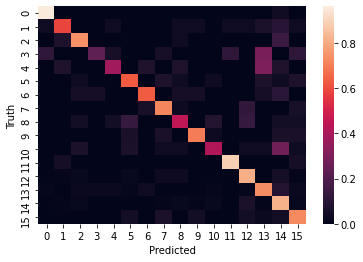

In [12]:
fig,ax = plt.subplots()
ax = sns.heatmap(sklearn.metrics.confusion_matrix(y_true_agg, y_pred_agg, labels=use_subjs, normalize='true'), ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Truth')
print('Confusion Matrix')

fig.savefig('images/confusion_matrix_3d.png')

This confusion matrix looks solid.